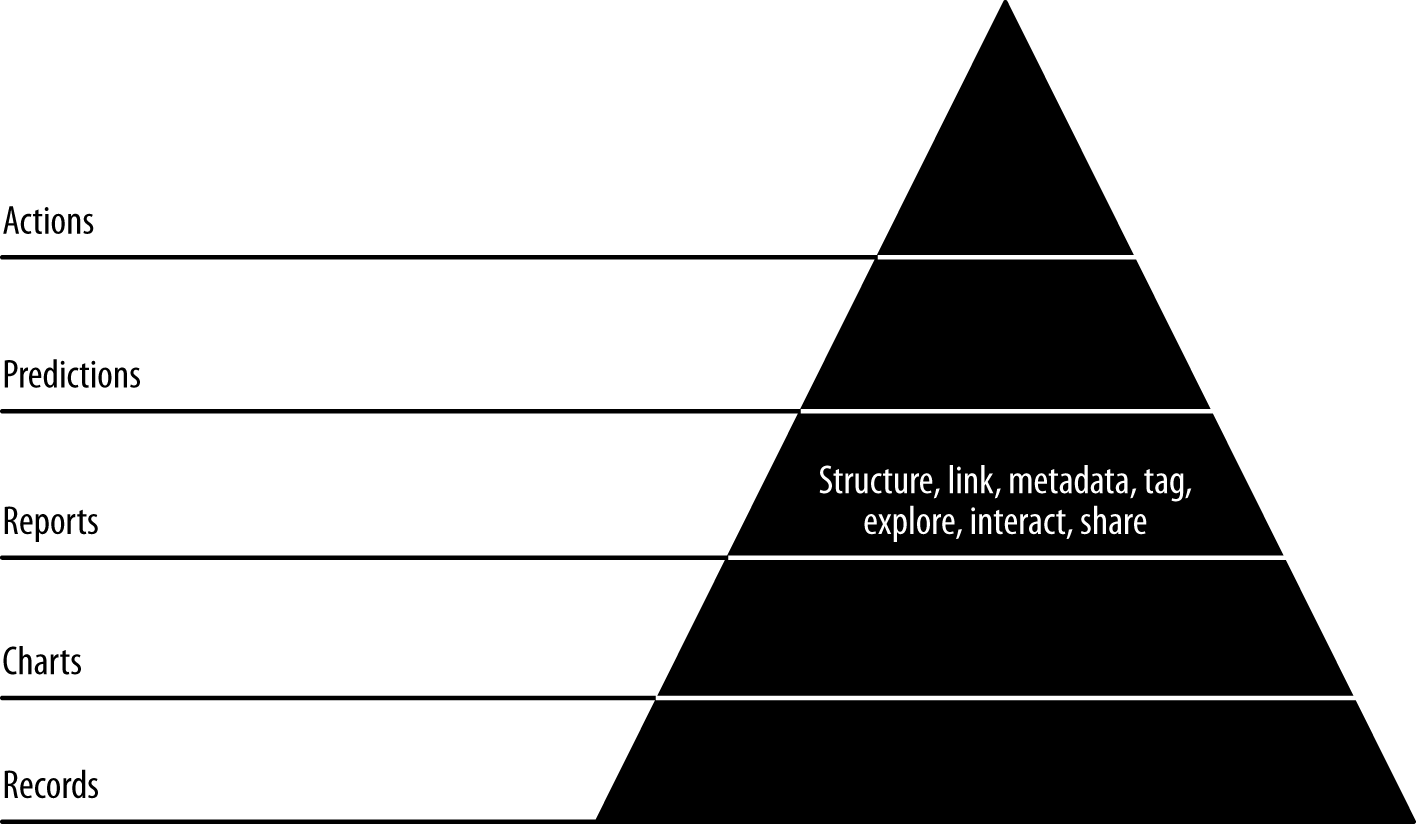

In the next step, our third agile sprint, we’ll extend our chart pages into full-blown reports. In this step, charts become interactive, static pages become dynamic, and our data becomes explorable through networks of linked, related entities with tables and charts. These are the characteristics of the reports stage of the data-value pyramid.

In [ ]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

## Extracting Airlines (Entities)

To build a report, we need to compose multiple views of our dataset. Building these views corresponds with enumerating entities. The entity we created in the previous chapter, airplanes, will serve as a foundation as we increase the number of entities and the corresponding links between them to create reports. As with the last chapter, before we can start creating different views on our data, we need a web page to put our charts and tables into. So let’s create another entity, airlines, and give each a page of its own.

We start by gathering all tail numbers for a given airline in a table on its entity page. Every commercial flight has an airline it operates under, and each airline has a fleet of beautifully branded airplanes that, along with airport facilities and staff, are the key assets of its business. We already created a page for each airplane, so we’ll leverage this data asset to create a list of all tail numbers for each airline.

### Defining Airlines as Groups of Airplanes Using PySpark

We begin by preparing the lists of tail numbers for each airline code, in [ch06/extract_airlines.py](extract_airlines.py). These will form the basis for our airline pages:

In [ ]:
# Load the on-time Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# The first step is easily expressed as SQL: get all unique tail numbers foreach airline
on_time_dataframe.registerTempTable("on_time_performance")
carrier_airplane = spark.sql(
  "SELECT DISTINCT Carrier, TailNum FROM on_time_performance"
)
carrier_airplane.show(5)

In [ ]:
# Now we need to store a sorted list of tail numbers for each carrier, along with a fleet count
tuple_pair = carrier_airplane.rdd.map(
    lambda nameTuple: (nameTuple[0], [nameTuple[1]])
)
tuple_pair.first()

In [ ]:
reduced_pairs = tuple_pair.reduceByKey(lambda a, b: a + b)
reduced_pairs.first()

In [ ]:
final_records = reduced_pairs.map(lambda tuple:
      {
        'Carrier': tuple[0], 
        'TailNumbers': sorted(
          filter(
            lambda x: x is not None and x != '', tuple[1] # empty string tail numbers were 
                                        # getting through
            )
          ),
        'FleetCount': len(tuple[1])
      }
    )
final_records.first()

In [ ]:
# Determine the total number of airlines in the dataset
total_airlines = final_records.count()
print("Total airlines making up US fleet: {}".format(total_airlines))

#### Storing to MongoDB

Next we'll store this data in the `airplanes_per_carrier` collection.

In [ ]:
# Save to Mongo in the airplanes_per_carrier relation
import pymongo_spark
pymongo_spark.activate()
final_records.saveToMongoDB(
  'mongodb://localhost:27017/agile_data_science.airplanes_per_carrier'
)

print("Records stored to MongoDB!")

#### Verifying Records in MongoDB

In [ ]:
%%bash

mongo agile_data_science --quiet --eval 'db.airplanes_per_carrier.count()'
mongo agile_data_science --quiet --eval 'db.airplanes_per_carrier.findOne()'

## Exercises

1. To practice preparing records like the one in this section, create the following dataset and store it to MongoDB in the `airports_per_airline` collection: a list all airports each airline goes to, keyed by airline code. The record should look like this:

  {
    "airline": "DL",
    "airports": [
      "ATL",
      "LAX",
      "SFO",
      ...
    ]
  }
  
  We will use this data in additional exercises.

### Building an Airline Page in Flask

Next we’ll create a controller for our airline page. Check out [ch06/web/report_flask.py](web/report_flask.py).

#### Airline Page Controller

Our Flask controller is simple. It accepts an airline carrier code and returns a page with a list of airplanes, by tail number, from Mongo:

```python
# Controller: Fetch an airplane entity page
@app.route("/airlines/<carrier_code>")
def airline(carrier_code):
  airline_airplanes = client.agile_data_science.airplanes_per_carrier.find_one(
    {'Carrier': carrier_code}
  )
  return render_template(
    'airlines.html',
    airline_airplanes=airline_airplanes,
    carrier_code=carrier_code
  )
```

#### Airline Page Template

Our template code creates an HTML bullet for each tail number. Check out [ch06/web/templates/airlines.html](web/templates/airlines.html):

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airlines">Airlines</a> / <a href="/airlines/{{carrier_code}}">{{carrier_code}}</a>

  <!-- Summary -->
  <p style="text-align: justify;">{{airline_summary.summary}}</p>
  <h4>Fleet: {{airline_airplanes.FleetCount}} Planes</h4>
  <ul class="nav nav-pills">
    {% for tail_number in airline_airplanes.TailNumbers -%}
    <li class="button">
      <a href="/airplanes/{{tail_number}}">{{tail_number}}</a>
    </li>
    {% endfor -%}
  </ul>
{% endblock %}
```

Now in a terminal, change directory to `ch06/web` and run the file `report_flask.py`:

```bash
cd ch06/web
python ./report_flask.py
```

#### Airline Page Result

Now you can visit the resulting web page at [http://localhost:5000/airlines2/DL](http://localhost:5000/airlines2/DL):

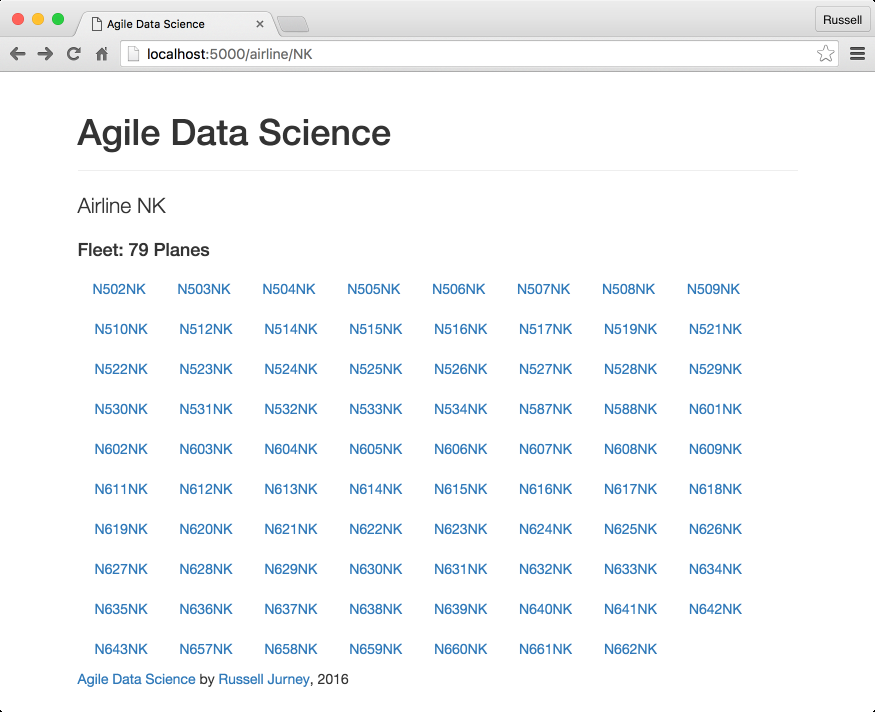

The result is the start of an airline page detailing its entire fleet. Don’t worry, we’ll dress this up later. It is absolutely necessary to ship something ugly before you ship something sharp!

## Exercises

1. Add a section to the Airline home page for the new dataset you prepared and published last exercise - the airports each airline services. Make each airport code in the page link to the url `/airports/<code>`. Don't worry, we'll create this page in a bit.

### Linking Back to Our Airline Page

Having created the airline entity page type, we will now link back to it from the airplane page we created, and the search and flight pages in from Chapter 5. We do this by editing the templates for the airplane, flight, and search pages.

We edit [ch06/web/templates/flights_per_airplane.html](web/templates/flights_per_airplane.html):

```html
    <table class="table table-condensed table-striped">
      ...
      <tbody>
        {% for flight in flights['Flights'] %}
        <tr>
          <td><a href="/airlines/{{flight['Carrier']}}">{{flight['Carrier']}}</a></td>
          <td>{{flight['FlightDate']}}</td>
          <td><a href="/on_time_performance?Carrier={{flight['Carrier']}}&FlightDate={{flight['FlightDate']}}&FlightNum={{flight['FlightNum']}}">{{flight['FlightNum']}}</a></td>
          <td>{{flight['Origin']}}</td>
          <td>{{flight['Dest']}}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
```

Now checkout [http://localhost:5000/airplane/flights/N35236](http://localhost:5000/airplane/flights/N35236):

We edit [ch06/web/templates/flight.html](web/templates/flight.html):

```html
    <table class="table">
      <thead>
        <th>Airline</th>
        <th>Origin</th>
        <th>Destination</th>
        <th>Tail Number</th>
        <th>Date</th>
        <th>Air Time</th>
        <th>Distance</th>
      </thead>
      <tbody>
        <tr>
          <td><a href="/airlines/{{flight.Carrier}}">{{flight.Carrier}}</a></td>
          <td>{{flight.Origin}}</td>
          <td>{{flight.Dest}}</td>
          <td><a href="/airplane/flights/{{flight.TailNum}}">{{flight.TailNum}}</a></td>
          <td>{{flight.FlightDate}}</td>
          <td>{{flight.AirTime}}</td>
          <td>{{flight.Distance}}</td>
        </tr>
      </tbody>
    </table>
```

Now checkout [http://localhost:5000/on_time_performance?Carrier=DL&FlightDate=2015-01-01&FlightNum=478](http://localhost:5000/on_time_performance?Carrier=DL&FlightDate=2015-01-01&FlightNum=478):

And finally we edit [ch06/web/templates/search.html](web/templates/search.html):

```html
    <table class="table table-condensed table-striped">
      ...
      <tbody>
        {% for flight in flights %}
        <tr>
          <td><a href="/airlines/{{flight.Carrier}}">{{flight.Carrier}}</a></td>
          <td><a href="/on_time_performance?Carrier={{flight.Carrier}}&FlightDate={{flight.FlightDate}}&FlightNum={{flight.FlightNum}}">{{flight.FlightNum}}</a></td>
          <td>{{flight.Origin}}</td>
          <td>{{flight.Dest}}</td>
          <td>{{flight.FlightDate}}</td>
          <td>{{flight.DepTime}}</td>
          <td><a href="/airplane/{{flight.TailNum}}">{{flight.TailNum}}</a></td>
          <td>{{flight.AirTime}}</td>
          <td>{{flight.Distance}}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
```

Now checkout [http://localhost:5000/flights/search](http://localhost:5000/flights/search)

## Exercises

In this exercise we will begin an __airport__ entity page that lives at `/airports/<code>`. We will start this page by preparing the first dataset we will display. Next we will store that data to MongoDB, verifying that is is present. Once the data is in MongoDB, we will create a simple Flask controller for our page, along with a simple HTML template. Finally we will display our dataset in our page, adding links to any entities that appear there.

1. Use the `Origin` and `Dest` fields in the `on_time_performance` dataset to prepare an intermediate dataset describing all the airlines that fly into or out of each airport. It should be keyed by a field called `code` and should contain a list entitled `airlines` with airline `Carrier` codes inside.
2. Store this data in the `airlines_per_airport` collection in MongoDB. 
3. Verify the data is present in MongoDB using the mongo client and `%%bash`.
4. Create a Flask controller and template for a new entity page located at `/airports/<code>`. 
5. Display the list of airlines that fly into each airport, ensuring that each airline code has a link to `/airlines/<carrier_code>`.

## Creating an All Airlines Home Page

But who knows airline carrier codes (okay, other than me)? We need a way to get users started browsing, so let’s create a home page listing all the airlines operating in the US.

Our controller is simple, just six lines of code. We’re able to reuse the airlines_per_carrier MongoDB collection, this time ignoring the tail numbers and only querying the carrier codes using a find. Let’s also direct users to this page by default, as our index.html for this application:

```python
# Controller: Fetch an airplane entity page
@app.route("/")
@app.route("/airlines")
@app.route("/airlines/")
def airlines():
  airlines = client.agile_data_science.airplanes_per_carrier.find()
  return render_template('all_airlines.html', airlines=airlines)
```

Our template is similar to the one for an individual airline:

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airlines">Airlines</a>

  <p class="lead">US Domestic Airlines</p>
  <ul class="nav nav-pills">
    {% for airline in airlines -%}
    <li class="button">
      <a href="/airlines/{{airline.Carrier}}">{{airline.Carrier}}</a>
    </li>
    {% endfor -%}
  </ul>
{% endblock %}
```

The result is a simple but effective way to get users browsing the world of aviation. Check out [http://localhost:5000/](http://localhost:5000):

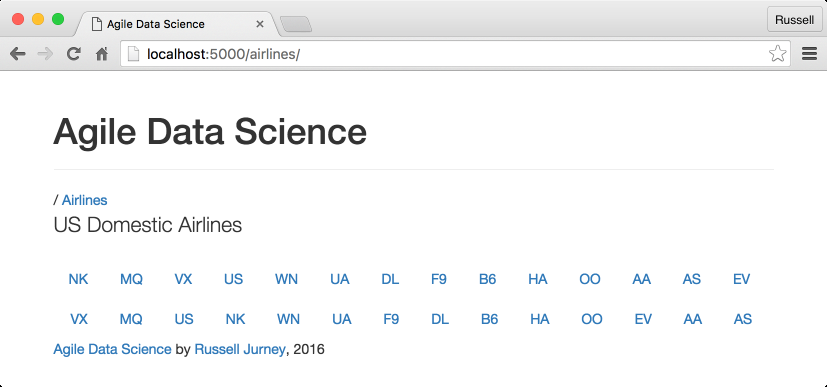

## Curating Ontologies of Semi-structured Data

We can now explore airlines, airplanes, and flights endlessly! Big deal, right? Maybe not, but it is a good start. Let’s extend this by making airplanes and airlines clickable in our flight pages.

Now we can look at airplanes and airlines, their properties, and their relationships as we view flights. This kind of pivot offers insight, and is a form of simple recommendation.

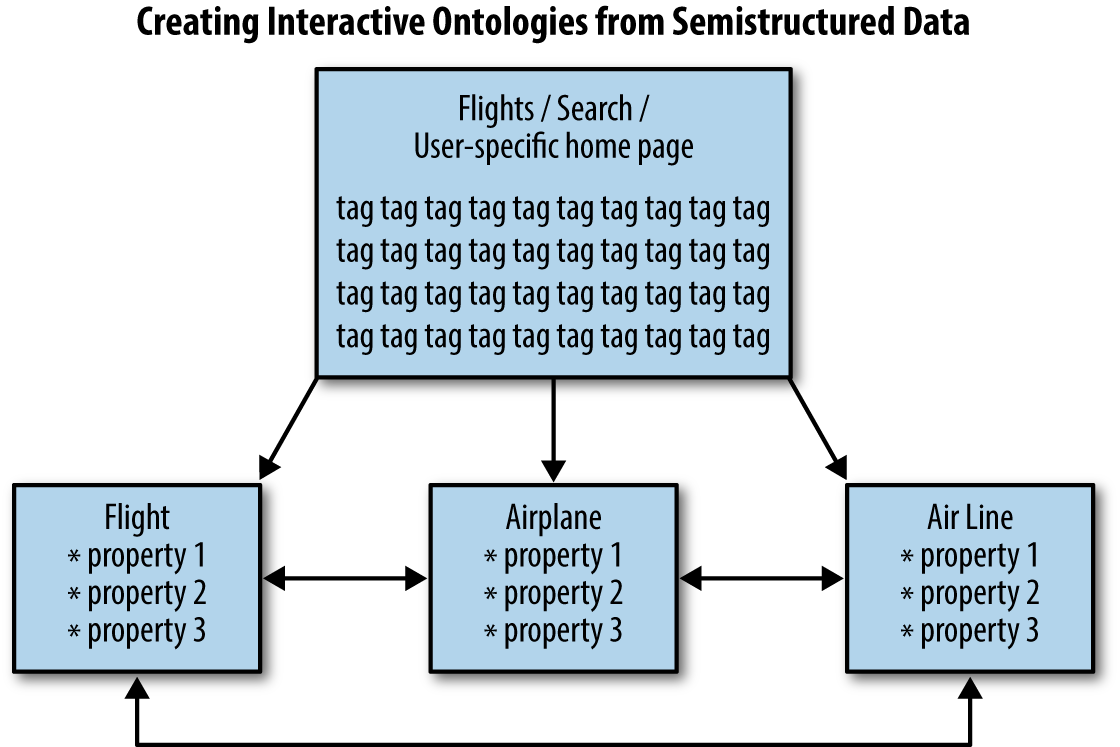

What we’re doing can be described as creating interactive ontologies of semi-structured data. Breaking up our process around building this kind of structure does several things for us. First, it creates small batches of work—one per entity—that break efficiently into agile sprints. This enables a kind of data agility, and also extends our application into a more and more browsable state. This in turn enables users to click around and explore our dataset, which connects the team into the ground truth or reality of the data—which, as you know by now, is a theme in Agile Data Science.

## Improving Airlines

Now that we’ve got airline pages, let’s improve them with some multimedia content: text and images. To begin, let’s get a list of the carrier codes in our primary dataset:

In [ ]:
# Load the on-time Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# The first step is easily expressed as SQL: get all unique tail numbers 
# for each airline
on_time_dataframe.registerTempTable("on_time_performance")
carrier_codes = spark.sql(
  "SELECT DISTINCT Carrier FROM on_time_performance"
)
carrier_codes.collect()

### Adding Names to Carrier Codes

In order to link more data to our carriers, we need to get the name of each along with the carrier code. This data is available in the airlines database we downloaded from OpenFlights in Chapter 5. Let’s inspect airlines.dat, which we’ve renamed airlines.csv:

In [ ]:
%%bash

cat ../data/airlines.csv | grep '"DL"\|"NW"\|"AA"'

#### Loading OpenFlights in PySpark

OpenFlights lists the fieldnames as Airline ID, Name, Alias, 2-Letter IATA Code, 3-Letter ICAO Code, Callsign, Country, and Active. Let’s open and inspect this data in PySpark. 

Check out [ch06/add_name_to_airlines.py](add_name_to_airlines.py):

In [ ]:
airlines = spark.read.format('com.databricks.spark.csv')\
  .options(
      header='false', 
      nullValue='\\N'
  )\
  .load('../data/airlines.csv')
airlines.show(5)

Lets check if Delta Airlines is in the data, carrier code `DL`.

In [ ]:
# Is Delta around?
airlines.filter(airlines._c3 == 'DL').show()

#### Joining FAA Carrier Codes to OpenFlights Carrier Records

Now let’s filter this data down to just the airline names and two-letter carrier codes, and join it to the unique carrier codes from the on-time performance dataset. As we did last chapter, we'll repartition the data to a single partition to get a single JSON file.

In [ ]:
# Drop fields except for C1 as name, C3 as carrier code
airlines.registerTempTable("airlines")
airlines = spark.sql("SELECT _c1 AS Name, _c3 AS CarrierCode from airlines")

# Check out the OpenFlights airlines record for Delta
airlines.filter(airlines.CarrierCode == 'DL').show()

# Check out the FAA codes record for Delta
carrier_codes.filter(carrier_codes.Carrier == 'DL').show()

# Join our 14 carrier codes to the airlines table to get our set of airlines
our_airlines = carrier_codes.join( 
  airlines, carrier_codes.Carrier == airlines.CarrierCode
)
our_airlines = our_airlines.select('Name', 'CarrierCode')
our_airlines.show()

our_airlines.repartition(1).write.mode('overwrite').json("../data/our_airlines.json")

#### Verifying Our Result

Now lets create a single JSON Lines file from the single partition JSON file and then check our result:

In [ ]:
%%bash

cat ../data/our_airlines.json/part*.json >> ../data/our_airlines.jsonl
head -5 ../data/our_airlines.jsonl

### Incorporating Wikipedia Content

Now that we have airline names, we can use Wikipedia to get various information about each airline, like a summary, logo, and company website! To do so, we make use of the wikipedia package for Python, which wraps the MediaWiki API. We’ll be using `BeautifulSoup` again to parse the page’s HTML.

Check out [ch06/enrich_airlines_wikipedia.py](enrich_airlines_wikipedia.py):

In [ ]:
import sys, os, re
sys.path.append("lib")
import utils

import wikipedia
from bs4 import BeautifulSoup
import tldextract

# Load our airlines...
our_airlines = utils.read_json_lines_file('../data/our_airlines.jsonl')

# Build a new list that includes Wikipedia data
with_url = []
for airline in our_airlines:
  
  # Get the Wikipedia page for the airline name
  wikipage = wikipedia.page(airline['Name'])

  # Get the summary
  summary = wikipage.summary
  airline['summary'] = summary

  # Get the HTML of the page
  page = BeautifulSoup(wikipage.html(), "lxml")

  # Task: get the logo from the right 'vcard' column
  # 1) Get the vcard table
  vcard_table = page.find_all('table', class_='vcard')[0]
  # 2) The logo is always the first image inside this table
  first_image = vcard_table.find_all('img')[0]
  # 3) Set the URL to the image
  logo_url = 'http:' + first_image.get('src')
  airline['logo_url'] = logo_url

  # Task: get the company website
  # 1) Find the 'Website' table header
  th = page.find_all('th', text='Website')[0]
  # 2) Find the parent tr element
  tr = th.parent
  # 3) Find the a (link) tag within the tr
  a = tr.find_all('a')[0]
  # 4) Finally, get the href of the a tag
  url = a.get('href')
  airline['url'] = url

  # Get the domain to display with the URL
  url_parts = tldextract.extract(url)
  airline['domain'] = url_parts.domain + '.' + url_parts.suffix

  print(airline)
  with_url.append(airline)

utils.write_json_lines_file(with_url, '../data/our_airlines_with_wiki.jsonl')

#### Verifying Our Result

Now check out our work:

In [ ]:
%%bash

head -1 ../data/our_airlines_with_wiki.jsonl

### Publishing Enriched Airlines to Mongo

Note that we skipped Mongo in this section—we went from our original dataset to two stages of enriched, intermediate datasets without storing to Mongo at all. This is fine! In Agile Data Science we use databases to publish data, not always to persist it in its intermediate state.

Now, however, we want to include our enriched airlines in the airline web pages we created earlier. To get it there, we need to send it through Mongo. Since we already have a JSON file prepared, we can use the mongoimport command to load it into Mongo:

In [ ]:
%%bash

mongoimport -d agile_data_science -c airlines --file ../data/our_airlines_with_wiki.jsonl

#### Verifying Records in Mongo

Now lets check for a record:

In [ ]:
%%bash

mongo agile_data_science --quiet --eval 'db.airlines.findOne()'

### Enriched Airlines on the Web

Now that our enriched airline records are in Mongo, we can alter our Flask controller for `/airlines` to include this data. Check out [ch06/web/report_flask.py](web/report_flask.py), where we've added the `airline_summary` data to a copy of the `airline` controller as `airline2`:

```python
# Controller: Fetch an airplane entity page
@app.route("/airlines2/<carrier_code>")
def airline2(carrier_code):
  airline_summary = client.agile_data_science.airlines.find_one(
    {'CarrierCode': carrier_code}
  )
  airline_airplanes = client.agile_data_science.airplanes_per_carrier.find_one(
    {'Carrier': carrier_code}
  )
  return render_template(
    'airlines2.html',
    airline_summary=airline_summary,
    airline_airplanes=airline_airplanes,
    carrier_code=carrier_code
  )
```

Next we alter our template, [ch06/web/templates/airlines2.html](web/templates/airlines2.html), to include the Wikipedia data:

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airlines">Airlines</a> / <a href="/airline/{{carrier_code}}">{{carrier_code}}</a>

  <!-- Logo -->
  <img src="{{airline_summary.logo_url}}" style="float: right;"/>

  <p class="lead">
    <!-- Airline Name and website-->
    {{airline_summary.Name}}
    / <a href="{{airline_summary.url}}">{{airline_summary.domain}}</a>
  </p>

  <!-- Summary -->
  <p style="text-align: justify;">{{airline_summary.summary}}</p>
  <h4>Fleet: {{airline_airplanes.FleetCount}} Planes</h4>
  <ul class="nav nav-pills">
    {% for tail_number in airline_airplanes.TailNumbers -%}
    <li class="button">
      <a href="/airplane/{{tail_number}}">{{tail_number}}</a>
    </li>
    {% endfor -%}
  </ul>
{% endblock %}
```

Now checkout [http://localhost:5000/airlines2/DL](http://localhost:5000/airlines2/DL): 

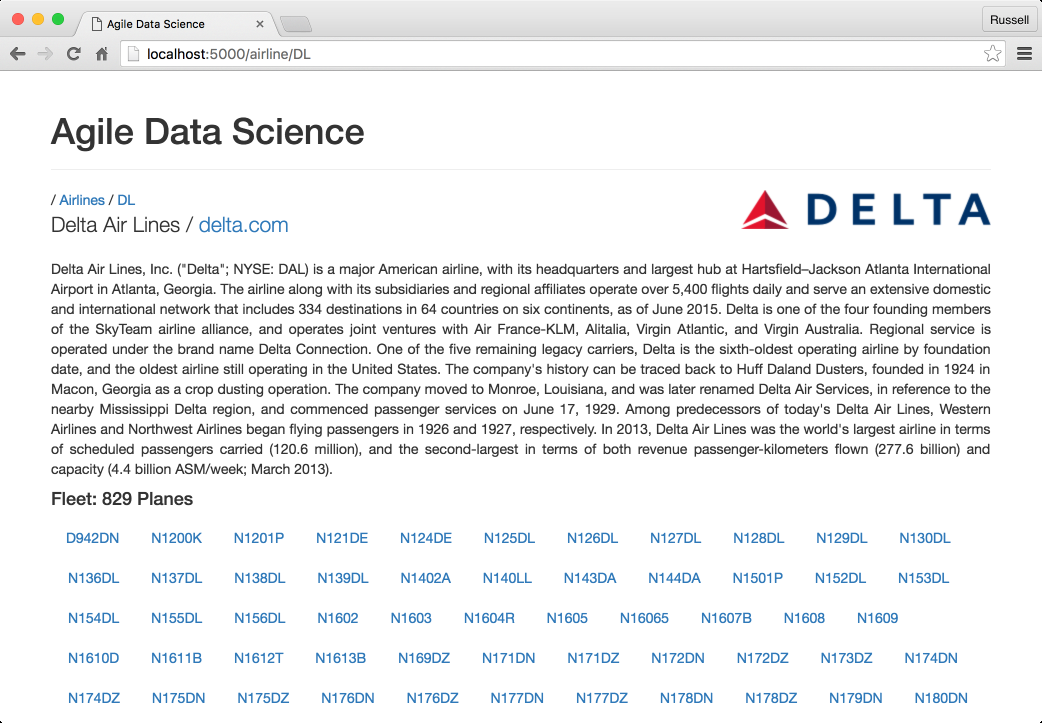

And for our labors, we get a greatly improved airline page. The point of this enrichment? While your data may not be so easily enhanced from a public dataset like Wikipedia, this example shows how to combine data from different sources, some private, some public, to compose better entity pages.

## Exercises

In this exercise we will enrich our airport entity page in the same way that we enriched our airline page. We will join data from OpenFlights and use this data to enrich our page further with data from wikipedia.

1. Use `%%bash` to inspect the dataset at `data/airports.csv`. Specifically, check out the record on `ATL`, Atlanta's airport.
2. Use PySpark to extract a list of unique airport codes from the `on_time_performance` data.
3. Use a join to enrich this list of airport codes with the aiport name and other data.
4. Create a new record containing the airport code, name, timezone, city, latitude and longitude.
5. Use the city field of the record to scrape wikipedia for additional information about that city. Extract a summary, and one or more image urls. Save this dataset to disk as JSON using the utilities shown above and in chapter 2.
6. Use `%%bash` and `mongoimport` to import this data into MongoDB as the `airport_information` collection.
7. Alter the template you created earlier for the Airport page to include this new information!

## Investigating Airplanes (Entities)

In Chapter 5, we were just getting into some interesting data that we will now look at once again. To begin, let’s store our enriched airplanes in their own intermediate dataset. Check out [ch06/prepare_airplanes.py](prepare_airlines.py):

In [ ]:
# Load the FAA N-Number inquiry records
faa_tail_number_inquiry = spark.read.json('../data/faa_tail_number_inquiry.jsonl')
faa_tail_number_inquiry.show()

# Count the records
faa_tail_number_inquiry.count()

# Load our unique tail numbers
unique_tail_numbers = spark.read.json('../data/tail_numbers.jsonl')
unique_tail_numbers.show()

# Join tail numbers to our inquries
tail_num_plus_inquiry = unique_tail_numbers.join(
  faa_tail_number_inquiry,
  unique_tail_numbers.TailNum == faa_tail_number_inquiry.TailNum,
)
tail_num_plus_inquiry = tail_num_plus_inquiry.drop(unique_tail_numbers.TailNum)
tail_num_plus_inquiry.show()

# Dump extra field and store tail_numbers plus inquiry
tail_num_plus_inquiry.registerTempTable("tail_num_plus_inquiry")
airplanes = spark.sql("""SELECT
  TailNum AS TailNum,
  engine_manufacturer AS EngineManufacturer,
  engine_model AS EngineModel,
  manufacturer AS Manufacturer,
  mfr_year AS ManufacturerYear,
  model AS Model,
  owner AS Owner,
  owner_state AS OwnerState,
  serial_number AS SerialNumber
FROM
  tail_num_plus_inquiry""")

airplanes.repartition(1).write.mode('overwrite').json('../data/airplanes.json')

As before, we can copy this directory of data into a single file for convenient access outside of Spark—note that this is not a good idea for very large files, but in this case our airplanes data is less than one megabyte:

In [ ]:
%%bash

cat ../data/airplanes.json/part* >> ../data/airplanes.jsonl
head -5 ../data/airplanes.jsonl

# Boeing Versus Airbus

Let’s begin our analysis by asking a question: Boeing versus Airbus—who manufactures more airplanes in the US commercial fleet? 

Note that we ORDER BY both the Total and the Manufacturer. Always employ an additional “tiebreaker” sort key like this, so that your results are repeatable. Without a second sort key, the order of the results is not specified by the query and is at the mercy of the SQL interpreter.

Check out [ch06/analyze_airplanes.py](analyze_airplanes.py):

In [ ]:
airplanes = spark.read.json('../data/airplanes.jsonl')
airplanes.registerTempTable("airplanes")

manufacturer_counts = spark.sql("""SELECT
  Manufacturer,
  COUNT(*) AS Total
FROM
  airplanes
GROUP BY
  Manufacturer
ORDER BY
  Total DESC"""
)
manufacturer_counts.show(10) # show top 30

Interesting, Boeing planes outnumber Airbus planes by 4 to 1! I had no idea; I thought it was much closer than this. However, what I really want to know is who has what share of the market (without having to compute a ratio in my head). In other words, I’d like to see this data as a percentage.

## SQL Subqueries Versus Dataflow Programming

This is a good way to illustrate the difference between SQL subqueries and dataflow programming. SQL is declarative, in that you specify what you want without saying how to get it. Imperative dataflow programming, on the other hand, involves the step-wise computation of data that you link and compose into dataflows.

First we’ll implement the percentage totals using imperative dataflows, and then we’ll do so using declarative SQL subqueries. You’ll see that in this case subqueries are more convenient, but there is a limit to the utility of subqueries—they can get obscure fast. It is better to create a series of simple SQL or dataflow statements that compose into the computation you desire rather than to try to specify it all in one large, deeply nested subquery.

### Dataflow Programming Without Subqueries

Subqueries weren’t supported in Spark SQL until 2.0. Instead, given our manufacturer airplane counts, we would need to calculate the total airplane count, join that to our existing totals, and then divide the manufacturer subtotals by the overall total. We’ll reuse the manufacturer_counts relation we computed in the previous program listing:

In [ ]:
# How many airplanes total?
total_airplanes = spark.sql(
  """SELECT
  COUNT(*) AS OverallTotal
  FROM airplanes"""
)
print("Total airplanes: {:,}".format(total_airplanes.collect()[0].OverallTotal))

In [ ]:
mfr_with_totals = manufacturer_counts.crossJoin(total_airplanes)
mfr_with_totals = mfr_with_totals.rdd.map(
  lambda x: {
    'Manufacturer': x.Manufacturer,
    'Total': x.Total,
    'Percentage': round(
      (
        float(x.Total)/float(x.OverallTotal)
      ) * 100,
      2
    )
  }
)
mfr_with_totals.toDF().show()

This is clearly an out-of-the-way method of calculating percentage totals, but it illustrates how dataflow programming works in more complex examples as well.

### Subqueries in Spark SQL

Subqueries are handy, and computing the percentage share of the aircraft manufacturers is easy using them:

In [ ]:
relative_manufacturer_counts = spark.sql("""SELECT
  Manufacturer,
  ROUND(
    100 * (
      COUNT(*)/(SELECT COUNT(*) FROM airplanes)
    ),
    2
  ) AS Percentage,
  COUNT(*) AS Total
FROM
  airplanes
GROUP BY
  Manufacturer
ORDER BY
  Total DESC, Manufacturer"""
)
relative_manufacturer_counts.show(20)

## Creating an Airplanes Home Page

Now I want to see this data as a chart on a web page, which means we need somewhere to put the chart. This is a good time to create an `/airplanes` home page—a page that analyzes the fleet as a whole.

Let’s create a Flask controller for `/airplanes`. Check out `ch06/web/report_flask.py`, which simply loads the data from Mongo and passes it to a template, `all_airplanes.html`:

```python
@app.route("/airplanes1")
@app.route("/airplanes1/")
def airplanes():
  mfr_chart = client.agile_data_science.manufacturer_totals.find_one()
  return render_template('all_airplanes.html',mfr_chart=mfr_chart)
```

To start, the template looks like this:

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airplanes">Airplanes</a>

  <p class="lead">
    <!-- Airline name and website-->
    US Commercial Fleet
  </p>
{% endblock %}
```

The result looks like this:

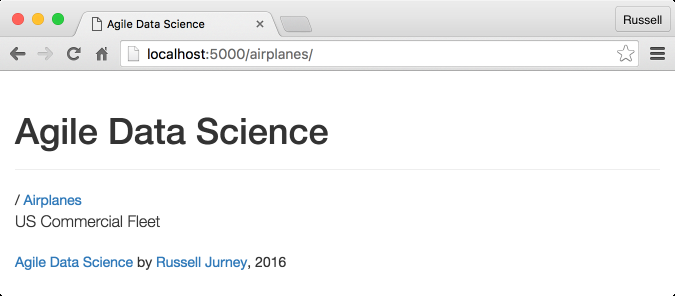

### Adding Search to the Airplanes Page

The `/airplanes` page is a great place to implement search for the airplane records we’ve created. To do this, first we’ll need to create a new search index and then index our airplane documents in Elasticsearch via PySpark:

In [ ]:
%%bash

curl -XPUT 'http://localhost:9200/agile_data_science_airplanes/' -d '{
    "settings" : {
        "index" : {
            "number_of_shards" : 1,
            "number_of_replicas" : 1
        }
    }
}'

In [ ]:
# Load our airplanes
airplanes = spark.read.json("../data/airplanes.json")
airplanes.show(10)

# Save the DataFrame to Elasticsearch
a = airplanes.rdd.map(lambda x: ('ignored_key', x.asDict()))

a.saveAsNewAPIHadoopFile(
  path='-', 
  outputFormatClass="org.elasticsearch.hadoop.mr.EsOutputFormat",
  keyClass="org.apache.hadoop.io.NullWritable", 
  valueClass="org.elasticsearch.hadoop.mr.LinkedMapWritable", 
  conf={ "es.resource" : "agile_data_science/airplanes" })

print("Records saved to Elasticsearch!")

We can verify our documents are there with a quick search:

In [ ]:
%%bash

curl -XGET 'http://localhost:9200/agile_data_science/airplanes/_search?q=*' | jq ''

Now we can add search capability to our `/airplanes` controller. Recall that we we did this in Chapter 5 for flight search, and that it took several pages of code. This time, we are going to build a reusable component for searching and displaying records in a Flask application.

### Code Versus Configuration

There are varying opinions on how much code duplication is acceptable before factoring it out, and this varies greatly by context and across programming disciplines. Data science has a higher tolerance for ugly, duplicated code than does general software engineering. This is for the simple reason that most code a data scientist writes is discarded immediately after it is run. Most data scientists are doing well to commit all their code to a repository at all (an absolute must!). But when code persists and we share the result, as in our application, cleanliness starts to matter.

This is the second time we’ve been tasked with implementing search, and when repeating oneself at length, it is a good time to take pause and see if one can’t reduce some of the redundant code necessary to reproduce a feature. (Because most code is throwaway in data science, it is important to wait until you repeat yourself to factor out duplicate code and generalize capabilities, as we have done here.)

Being tasked with generalizing code, we have to split our code into two elements: algorithms and configuration. Algorithms define the behavior of what we’re building; configuration defines what an instance of that algorithm is like.

To take one extreme, it is possible in programming to remove all redundancy in code, to the point that everything becomes a configuration file or an algorithm implementing the behavior of a configuration. This extreme, however, is not maintainable and isn’t compatible with a data scientist’s workload, where we have to remember lots of things at once and can’t dive deep into each component just to edit or make use of it. As usual in Agile Data Science, we choose the middle path, where we remove the worst of the redundancy without reducing everything to its most generalized, reusable form.

### Configuring a Search Widget

Our search configuration is simple. It lays out the fields we will search and display, and an optional label we would like to use in the user interface:

```python
  search_config = [
    {'field': 'TailNum', 'label': 'Tail Number'},
    {'field': 'Owner', 'sort_order': 0},
    {'field': 'OwnerState', 'label': 'Owner State'},
    {'field': 'Manufacturer', 'sort_order': 1},
    {'field': 'Model', 'sort_order': 2},
    {'field': 'ManufacturerYear', 'label': 'MFR Year'},
    {'field': 'SerialNumber', 'label': 'Serial Number'},
    {'field': 'EngineManufacturer', 'label': 'Engine MFR', 'sort_order': 3},
    {'field': 'EngineModel', 'label': 'Engine Model', 'sort_order': 4}
  ]
```

Our pagination works as before, but we’ve got a new configuration item for `AIRPLANE_RECORDS_PER_PAGE`:

```python
  # Pagination parameters
  start = request.args.get('start') or 0
  start = int(start)
  end = request.args.get('end') or config.AIRPLANE_RECORDS_PER_PAGE
  end = int(end)

  # Navigation path and offset setup
  nav_path = search_helpers.strip_place(request.url)
  nav_offsets = search_helpers.get_navigation_offsets(
    start, 
    end, 
    config.AIRPLANE_RECORDS_PER_PAGE
  )
```


With our search config in hand, we need only define the base of the Elasticsearch query and flesh it out based on the search arguments we receive. Our base query looks like this:

```python
  # Build the base of our elasticsearch query
  query = {
    'query': {
      'bool': {
        'must': []}
    },
    'from': start,
    'size': config.AIRPLANE_RECORDS_PER_PAGE
  }
```

And we parameterize it like so:

```python
  arg_dict = {}
  for item in search_config:
    field = item['field']
    value = request.args.get(field)
    arg_dict[field] = value
    if value:
      query['query']['bool']['must'].append({'match': {field: value}})
```

We submit the query as before:

```python
  # Query elasticsearch, process to get records and count
  results = elastic.search(query, index='agile_data_science_airplanes')
  airplanes, airplane_count = search_helpers.process_search(results)
```

In our call to render our template, we now include the search_config and arg_dict, which will generate our content in the template:

```python
  # Persist search parameters in the form template
  return render_template(
    'all_airplanes.html',
    search_config=search_config,
    args=arg_dict,
    airplanes=airplanes,
    airplane_count=airplane_count,
    nav_path=nav_path,
    nav_offsets=nav_offsets,
  )
```

Our template, `all_airplanes.html`, is derived from `search.html` from chapter 5. Using `search_config` and the request arguments, we programmatically build all the content we manually specified before in search.html. We can reuse this code now to re-create any search controller:

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airplanes">Airplanes</a>

  <p class="lead" style="margin: 10px; margin-left: 0px;">
    <!-- Airline Name and website-->
    US Commercial Fleet
  </p>

  <!-- Chart of fleet manufacturers -->
  <div>
    <p style="margin: 0px;">Airplanes by Manufacturer</p>
    <div id="chart"><svg class="chart"></svg></div>
  </div>
  <script src="/static/airplanes.js"></script>

  <!-- Generate form from search_config and request args -->
  <form action="/airplanes" method="get">
    {% for item in search_config %}
      {% if 'label' in item %}
        <label for="{{item['field']}}">{{item['label']}}</label>
      {% else %}
        <label for="{{item['field']}}">{{item['field']}}</label>
      {% endif %}
        <input name="{{item['field']}}" style="width: 36px; margin-right: 10px;" value="{{args[item['field']] if args[item['field']] else ''}}"></input>
    {% endfor %}
    <button type="submit" class="btn btn-xs btn-default" style="height: 25px">Submit</button>
  </form>

  <table class="table table-condensed table-striped">
    <!-- Create table header, based on search_config -->
    <thead>
      {% for item in search_config %}
        {% if 'label' in item %}
          <th>{{item['label']}}</th>
        {% else %}
          <th>{{item['field']}}</th>
        {% endif %}
      {% endfor %}
    </thead>

    <!-- Create table content, based on airplanes for each <tr> and search_config for each <td> -->
    <tbody>
      {% for airplane in airplanes %}
      <tr>
        {% for item in search_config %}
          <td>{{airplane[item['field']]}}</td>
        {% endfor %}
      </tr>
      {% endfor %}
    </tbody>
  </table>

  <!-- css for x axis in chart -->
  <style>
    .axis text {
      font: 8px sans-serif;
    }

    .axis path,
    .axis line {
      fill: none;
      stroke: #000;
      shape-rendering: crispEdges;
    }

    .bar {
      fill: #ff6600;
    }
  </style>

{% import "macros.jnj" as common %}
{% if nav_offsets and nav_path -%}
  {{ common.display_nav(nav_offsets, nav_path, airplane_count)|safe }}
{% endif -%}
{% endblock %}
```

Check out the resulting search at [http://localhost:5000/airplanes](http://localhost:5000/airplanes)

## Creating a Manufacturers Bar Chart

Now that we’ve got a place to put our chart, let’s get down to creating it!

Continuing with our script, [ch06/analyze_airplanes.py](analyze_airplanes.py), we store the data for the chart in Mongo:

In [ ]:
#
# Now get these things on the web
#
relative_manufacturer_counts_dicts = relative_manufacturer_counts.rdd.map(lambda row: row.asDict())
grouped_manufacturer_counts = relative_manufacturer_counts_dicts.groupBy(lambda x: 1)

# Save to Mongo in the airplanes_per_carrier relation
import pymongo_spark
pymongo_spark.activate()
grouped_manufacturer_counts.saveToMongoDB(
  'mongodb://localhost:27017/agile_data_science.airplane_manufacturer_totals'
)

print("Records stored to MongoDB!")

Next, check that the data is in Mongo:

In [ ]:
%%bash

mongo agile_data_science --quiet --eval 'db.airplane_manufacturer_totals.findOne()'

The rest is similar to the bar chart from Chapter 5. We add a controller to [ch06/web/report_flask.py](web/report_flask.py) where we grab the chart from Mongo, and return it as JSON:

```python
@app.route("/airplanes/chart/manufacturers.json")
@app.route("/airplanes/chart/manufacturers.json")
def airplane_manufacturers_chart():
  mfr_chart = client.agile_data_science.airplane_manufacturer_totals.find_one()
  return json.dumps(mfr_chart)
```

Then we edit the [ch06/web/templates/all_airplanes.html](web/templates/all_airplanes.html) template to call [ch06/web/static/airplanes.js](web/static/airplanes.js), which draws the chart.

This time we want x- and y-axes for our bar chart, so we’re going to draw from an example that includes them. Mike Bostock’s example Bar Chart IIIc is concise and straightforward. Let’s begin by titling our page and calling our chart script, `airplanes.js`:

```html
  <!-- Chart of fleet manufacturers -->
  <div>
    <p style="margin: 0px;">Airplanes by Manufacturer</p>
    <div id="chart"><svg class="chart"></svg></div>
  </div>
  <script src="/static/airplanes.js"></script>
```

[ch06/web/static/airplanes.js](web/static/airplanes.js) has a few changes to make the example work for our chart’s data. Aside from plugging in the Total and Manufacturer field names and passing through the data.data field, we haven’t changed anything except the dimensions of the chart:

```javascript
var margin = {top: 20, right: 30, bottom: 30, left: 40},
    width = 900 - margin.left - margin.right,
    height = 300 - margin.top - margin.bottom;

var x = d3.scale.ordinal()
    .rangeRoundBands([0, width], .1);
var y = d3.scale.linear()
    .range([height, 0]);

var xAxis = d3.svg.axis()
    .scale(x)
    .orient("bottom")
    .tickFormat(function(d) {
        return truncate(d, 14);
    });
var yAxis = d3.svg.axis()
    .scale(y)
    .orient("left");

var chart = d3.select(".chart")
    .attr("width", width + margin.left + margin.right)
    .attr("height", height + margin.top + margin.bottom)
    .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.json("/airplanes/chart/manufacturers.json", function(error, data) {
    var data = data.data;

    x.domain(data.map(function(d) { return d.Manufacturer; }));
    y.domain([0, d3.max(data, function(d) { return d.Total; })]);

    chart.append("g")
        .attr("class", "x axis")
        .attr("transform", "translate(0," + height + ")")
        .call(xAxis);

    chart.append("g")
        .attr("class", "y axis")
        .call(yAxis);

    chart.selectAll(".bar")
        .data(data)
        .enter().append("rect")
        .attr("class", "bar")
        .attr("x", function(d) { return x(d.Manufacturer); })
        .attr("y", function(d) { return y(d.Total); })
        .attr("height", function(d) { return height - y(d.Total); })
        .attr("width", x.rangeBand());
});

function truncate(d, l) {
     if(d.length > l)
         return d.substring(0,l)+'...';
     else
         return d;
}
```

And for our trouble, we get a beautiful chart at [http://localhost:5000/airplanes](http://localhost:5000/airplanes):

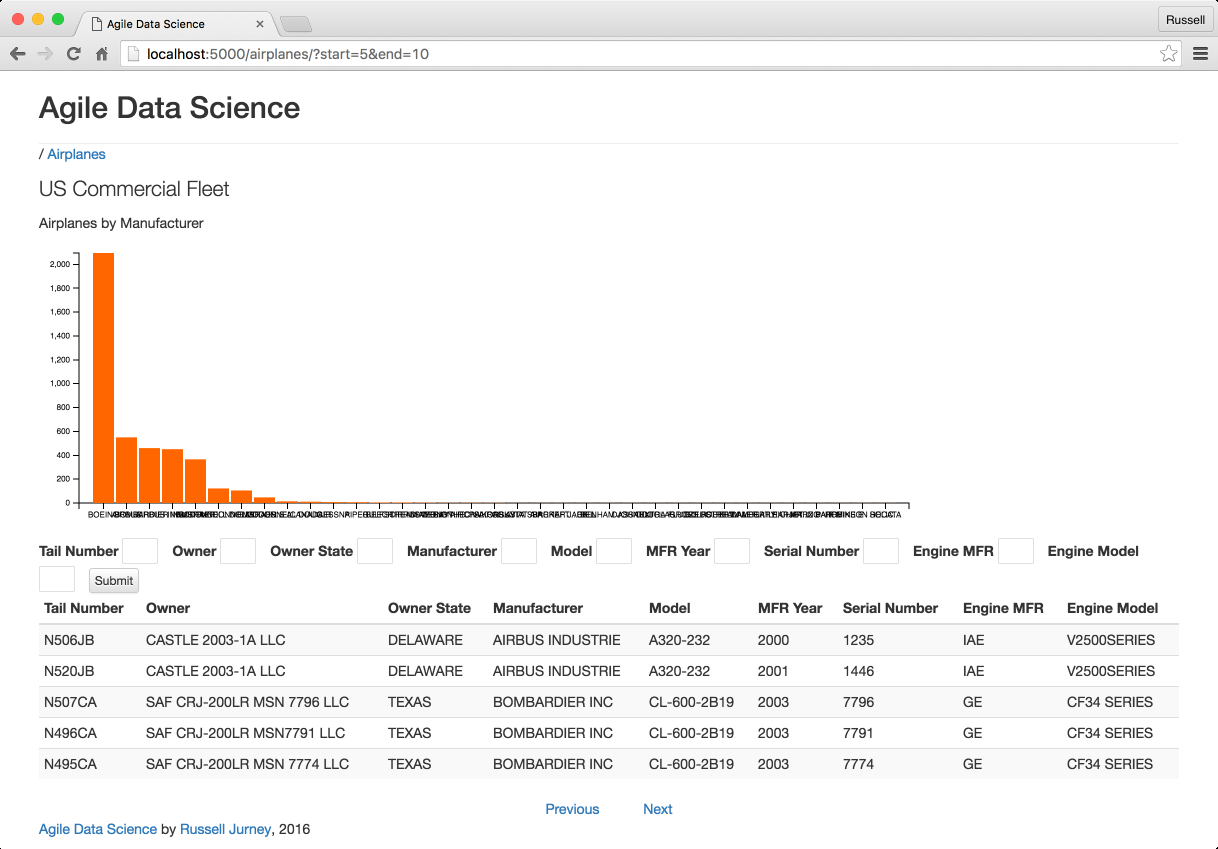

## Exercises

In this exercise we will create a `/airports` home page describing America's airports. 

1. Begin with a simple Flask controller and HTML template for the page, and verify that it works. 
2. Prepare a dataset for a chart for the page. Create a bar chart showing the number of flights out of the top 20 most busy airports in the US in 2015. Label the chart with full airport names, not just codes.
3. Publish this dataset to MongoDB and verify it is there.
4. Implement a controller serving the data for the chart as JSON.
5. Implement the bar chart in d3.js

## Iterating on the Manufacturers Bar Chart

Wait a minute, something is wrong! Remember when we said iteration is essential? Let’s debug this chart. We need to infer from the chart what might be going on. Why are the bars so thin? Why are they shoved to the left?

Recall that we sorted the data by `Total` in descending order:

```python
relative_manufacturer_counts = spark.sql("""SELECT
  Manufacturer,
  ROUND(
    100 * (
      COUNT(*)/(SELECT COUNT(*) FROM airplanes)
    ),
    2
  ) AS Percentage,
  COUNT(*) AS Total
FROM
  airplanes
GROUP BY
  Manufacturer
ORDER BY
  Total DESC, Manufacturer
LIMIT 20"""
)
```

This means that the largest values are on the left, and the smallest values are on the right… so what must be happening is that there are simply too many small values to make the chart readable! We can improve the chart by removing some of these smaller values, since they are insignificant. Note that this won’t always be the case, so think carefully before discarding data!

We can fix up our chart by recomputing the data using a SQL LIMIT command. First, we need to drop the stale data from Mongo:

In [ ]:
%%bash

mongo agile_data_science --quiet --eval 'db.airplane_manufacturer_totals.drop()'

In [ ]:
relative_manufacturer_counts = spark.sql("""SELECT
  Manufacturer,
  COUNT(*) AS Total,
  ROUND(
    100 * (
      COUNT(*)/(SELECT COUNT(*) FROM airplanes)
    ),
    2
  ) AS PercentageTotal
FROM
  airplanes
GROUP BY
  Manufacturer
ORDER BY
  Total DESC, Manufacturer
LIMIT 10""")
relative_manufacturer_counts.show()

In [ ]:
#
# Now get these things on the web
#
relative_manufacturer_counts_dicts = relative_manufacturer_counts.rdd.map(lambda row: row.asDict())
grouped_manufacturer_counts = relative_manufacturer_counts_dicts.groupBy(lambda x: 1)

# Save to Mongo in the airplanes_per_carrier relation
import pymongo_spark
pymongo_spark.activate()
grouped_manufacturer_counts.saveToMongoDB(
  'mongodb://localhost:27017/agile_data_science.airplane_manufacturer_totals'
)

print("Records stored to MongoDB!")

Now check out [http://localhost:5000/airplanes](http://localhost:5000/airplanes) again!

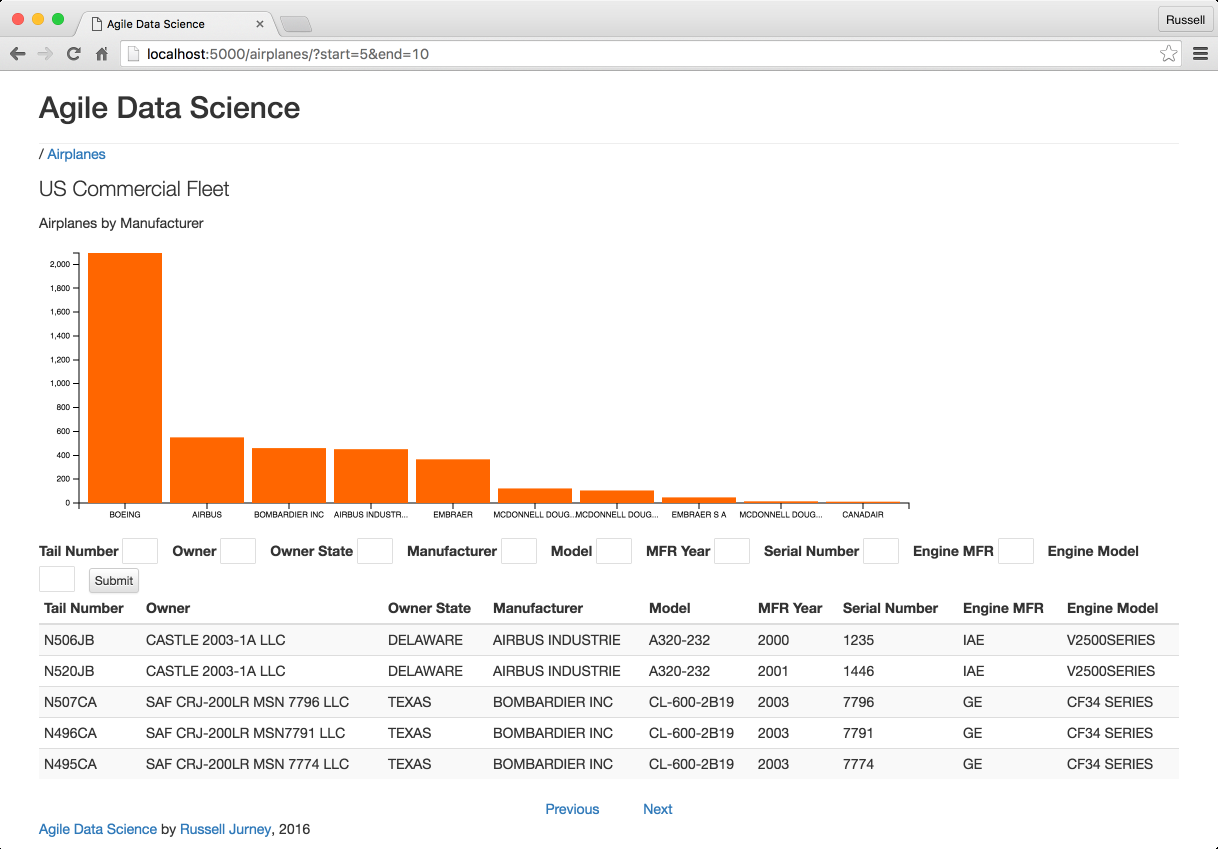

Running our new script and pushing our new data to Mongo results in something that clearly shows the trend of Boeing dominating the market, trailed by several other manufacturers. Note that we also created a function called truncate to shorten long manufacturer names in the x-axis, so these labels do not overlap. We call this function from the tickFormat method on our xAxis object:

```javascript
function truncate(d, l) {
     if(d.length > l)
         return d.substring(0,l)+'...';
     else
         return d;
}
```

## Entity Resolution: Another Chart Iteration

However, there is another problem with the chart—the column names are duplicated, which is distorting the values of manufacturers Airbus, McDonnel Douglas, and Embraer. We need to iterate yet again! This time we’ll be tackling entity resolution.

### Entity Resolution in 30 Seconds

The problem we have encountered is that there are several forms of the manufacturers’ names used in the registrations of various airplanes. Addressing this problem is called entity resolution, which is defined in a tutorial by Lise Getoor and Ashwin Machanavajjhala as “[the] problem of identifying and linking/grouping different manifestations of the same real world object.” Entity resolution is the process by which AIRBUS is identified as the same thing as `AIRBUS INDUSTRIE`.

There are many methods of entity resolution, including complicated means employing statistical inference. We will only explore a simple heuristic-based approach, because it turns out that in this case that is simply good enough. Don’t allow your curiosity to distract you into employing machine learning and statistical techniques whenever you can. Get curious about results, instead.

### Resolving Manufacturers in PySpark

Let’s begin by inspecting the different ways the Manufacturer field appears in the airplane records. We can use SQL to `SELECT DISTINCT(Manufacturer) AS Manufacturer` and then see similar records next to one another with `ORDER BY Manufacturer`. Then we need only print the data in a left-justified manner, and see what we’ve got!

This results in a list that allows us to easily visualize the variety of values of Manufacturer:

In [ ]:
airplanes = spark.read.json('../data/airplanes.json')

airplanes.registerTempTable("airplanes")
manufacturer_variety = spark.sql(
"""SELECT
  DISTINCT(Manufacturer) AS Manufacturer
FROM
  airplanes
ORDER BY
  Manufacturer"""
)
manufacturer_variety_local = manufacturer_variety.collect()

# We need to print these left justified
for mfr in manufacturer_variety_local:
  print(mfr.Manufacturer)

It turns out that we don’t have very much variety at all: only 35 distinct values. Reconciling the Manufacturer field of these records could be done manually, with a simple table elaborating the matches in two columns. One column would contain the raw value, and the other would contain the value to map to (the “standard” you have chosen). Against this table you can then LEFT JOIN and, if there is a match, replace the value of the field, in order to get a common identifier between records.

If you encounter 35 values for a field in your work, do yourself a favor: make the table manually as CSV and load it in Spark and do the join. Here we will go further to illustrate how to create such a mapping table in an automated way, and how to JOIN it and effect the mapping. We do this to give you experience in how to problem solve and “munge” your way out of these situations when you can without having to turn to more complex (and thus time-consuming) statistical techniques.

A more sophisticated approach would be to inspect the data and see if we can infer a rule to use to decide if records are identical. In looking at our duplicates, it seems that whenever there is a duplicate, there is a lot of overlap at the start of the strings. This is common among company names in the wild, where trailing symbols like “Incorporated” are shortened to “Inc,” “Inc.,” “INC,” “Corp,” etc. We might then formulate a strategy: if fields between records contain more than N characters in common at the start of the string, they are identical. We would choose the longest common substring as the “standard” value among those records, and use this rule to create our mapping table.

To employ this strategy, we need to compare all unique values of Manufacturer with one another. This is feasible with 35 unique values, but keep in mind that this may not always be the case when resolving entities. Sometimes it is impossible to compare all records with one another, because the square of the number of unique records is too big, even for Spark! In this case we’re only resolving one field, which keeps the cardinality low by enabling us to use the unique values of just that one field. When records have numerous fields that identify them, the number of unique records explodes. That situation is (thankfully) beyond the scope of this book, but I’ve had good experiences with the Swoosh algorithms, which are implemented in the SERF project from Stanford.

Check out [ch06/resolve_airplane_manufacturers.py](resolve_airplane_manufacturers.py). Here we prepare a mapping table for similar `Manufacturer` values, using the assumption that strings whose beginnings overlap by more than five characters are the same. Note that this assumption is naive and would not work for most datasets. Nonetheless, it shows how you can munge your way out of sticky situations by learning your dataset and actually looking at the data, record by sorted, unique record.

Continuing from the last code example where we computed manufacturer_variety, check out the inline comments that describe the computation here:

In [ ]:
# Detect the longest common beginning string in a pair of strings
def longest_common_beginning(s1, s2):
  if s1 == s2:
    return s1
  min_length = min(len(s1), len(s2))
  i = 0
  while i < min_length:
    if s1[i] == s2[i]:
      i += 1
    else:
      break
  return s1[0:i]

In [ ]:
# Compare two manufacturers, returning a tuple describing the result
def compare_manufacturers(mfrs):
  mfr1 = mfrs[0]
  mfr2 = mfrs[1]
  lcb = longest_common_beginning(mfr1, mfr2)
  lcb = lcb.strip() # remove extra spaces
  len_lcb = len(lcb)
  record = {
    'mfr1': mfr1,
    'mfr2': mfr2,
    'lcb': lcb,
    'len_lcb': len_lcb,
    'eq': mfr1 == mfr2
  }
  return record

In [ ]:
# Pair every unique instance of Manufacturer field with every other for comparison
comparison_pairs = manufacturer_variety.crossJoin(manufacturer_variety)

# Do the comparisons
comparisons = comparison_pairs.rdd.map(compare_manufacturers)

# Matches have > 5 starting chars in common
matches = comparisons.filter(lambda f: f['eq'] == False and f['len_lcb'] > 5)

matches.take(5)

In [ ]:
#
# Now we create a mapping of duplicate keys from their raw value to the one we're going to use
#

# 1) Group the matches by the longest common beginning ('lcb')
common_lcbs = matches.groupBy(lambda x: x['lcb'])

# 2) Emit the raw value for each side of the match along with the key, our 'lcb'
mfr1_map = common_lcbs.map(lambda x: [(y['mfr1'], x[0]) for y in x[1]]).flatMap(lambda x: x)
mfr2_map = common_lcbs.map(lambda x: [(y['mfr2'], x[0]) for y in x[1]]).flatMap(lambda x: x)

# 3) Combine the two sides of the comparison's records
map_with_dupes = mfr1_map.union(mfr2_map)

# 4) Remove duplicates
mfr_dedupe_mapping = map_with_dupes.distinct()

# 5) Convert mapping to dataframe to join to airplanes dataframe
mapping_dataframe = mfr_dedupe_mapping.toDF()

# 6) Give the mapping column names
mapping_dataframe.registerTempTable("mapping_dataframe")
mapping_dataframe = spark.sql(
  "SELECT _1 AS Raw, _2 AS NewManufacturer FROM mapping_dataframe"
)

# JOIN our mapping left outer...
airplanes_w_mapping = airplanes.join(
  mapping_dataframe,
  on=airplanes.Manufacturer == mapping_dataframe.Raw,
  how='left_outer'
)

# Now replace Manufacturer with NewManufacturer where needed
airplanes_w_mapping.registerTempTable("airplanes_w_mapping")
resolved_airplanes = spark.sql("""SELECT
  TailNum,
  SerialNumber,
  Owner,
  OwnerState,
  IF(NewManufacturer IS NOT null,NewManufacturer,Manufacturer) AS Manufacturer,
  Model,
  ManufacturerYear,
  EngineManufacturer,
  EngineModel
FROM
  airplanes_w_mapping""")

# Store for later use, in place of airplanes.json
resolved_airplanes.repartition(1).write.mode("overwrite").json("../data/resolved_airplanes.json")

Now we can employ the mapping table we have created. Note that this table could have been prepared manually, given the small number of records, and in that case this is the point at which you would load the mapping table as CSV (and run the next code block):

In [ ]:
# JOIN our mapping left outer...
airplanes_w_mapping = airplanes.join(
  mapping_dataframe,
  on=airplanes.Manufacturer == mapping_dataframe.Raw,
  how='left_outer'
)

# Now replace Manufacturer with NewManufacturer where needed
airplanes_w_mapping.registerTempTable("airplanes_w_mapping")
resolved_airplanes = spark.sql("""SELECT
  TailNum,
  SerialNumber,
  Owner,
  OwnerState,
  IF(NewManufacturer IS NOT null,NewManufacturer,Manufacturer) AS Manufacturer,
  Model,
  ManufacturerYear,
  EngineManufacturer,
  EngineModel
FROM
  airplanes_w_mapping""")

# Store for later use, in place of airplanes.json
resolved_airplanes.repartition(1).write.mode("overwrite").json("../data/resolved_airplanes.json")

Again, for convenience, let’s create a single JSON Lines file and check out the result:

In [ ]:
%%bash

cat ../data/resolved_airplanes.json/part* >> ../data/resolved_airplanes.jsonl
head -5 ../data/resolved_airplanes.jsonl

### Cleaning out MongoDB

Now we need to drop our original collection and re-calculate the data for the chart.

In [ ]:
%%bash

mongo agile_data_science --quiet --eval 'db.airplane_manufacturer_totals.drop()'

We need to run the code below, which is just a copy of the original [ch06/analyze_airplanes.py](analyze_airplanes.py) with the new path for our resolved airplanes plugged in.

In [ ]:
airplanes = spark.read.json('../data/resolved_airplanes.json')

airplanes.registerTempTable("airplanes")

#
# Same with sub-queries
#
relative_manufacturer_counts = spark.sql("""SELECT
  Manufacturer,
  COUNT(*) AS Total,
  ROUND(
    100 * (
      COUNT(*)/(SELECT COUNT(*) FROM airplanes)
    ),
    2
  ) AS PercentageTotal
FROM
  airplanes
GROUP BY
  Manufacturer
ORDER BY
  Total DESC, Manufacturer
LIMIT 10"""
)
relative_manufacturer_counts.show(30) # show top 30

#
# Now get these things on the web
#
relative_manufacturer_counts_dict = relative_manufacturer_counts.rdd.map(lambda row: row.asDict())
grouped_manufacturer_counts = relative_manufacturer_counts_dict.groupBy(lambda x: 1)

# Save to Mongo in the airplanes_per_carrier relation
import pymongo_spark
pymongo_spark.activate()
grouped_manufacturer_counts.saveToMongoDB(
  'mongodb://localhost:27017/agile_data_science.airplane_manufacturer_totals'
)

print("Data stored to MongoDB!")

Once you’ve done that, check out [http://localhost:5000/airplanes](http://localhost:5000/airplanes) to see the updated chart:

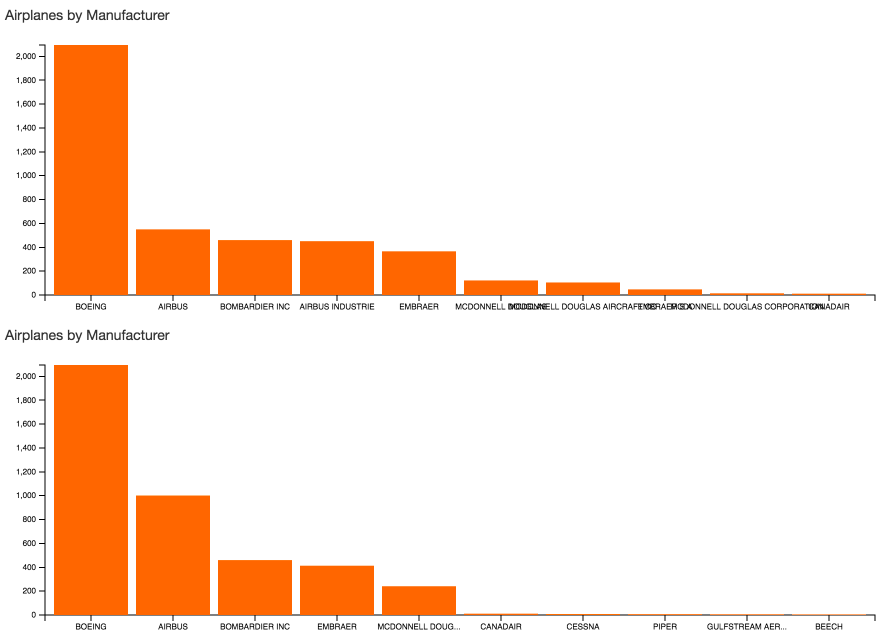

The chart has changed quite a bit now that we’ve deduplicated manufacturers! Airbus isn’t so far behind as we had thought. Now I’m wondering precisely how much market share each manufacturer has using the new airplanes dataframe.

It turns out that Boeing has 49% of the market, versus Airbus with 23.4%. Go Boeing! (Or, in case you’re in Europe... go Airbus!)

##  Cleanliness: Benefits of Entity Resolution

Raw data is always dirty. Once you dive in and start working with data and look at it in raw form, when you visualize it in web pages in tables and charts and make it searchable, problems with the data emerge. Resolving these problems as you work with the data enables you to see trends clearly, without distortion. As your visualizations benefit, so will your models. This “cleaning” sets you up for success in building effective statistical models in the next level of the data-value pyramid: predictions.

# Conclusion

Here’s a summary of what we’ve done so far:

1. Create interesting, interconnected records. The bar for “interesting” is initially low. We will improve it over time based on user feedback, traffic analysis, and noodling.

  Store these records as objects in a document store, like so:

    key => {property1, property2, links => [key1, key2, key3]}
    
2. Split records as properties increase and become complex to avoid deep nesting, or go at it as a document. Both approaches are valid if they fit your data.

3. Use a lightweight web framework like Flask or Sinatra to emit the key/value data as JSON, or use a document store that returns JSON in the first place.

In the next chapter, we’ll take what we’ve learned about our data to make a prediction with lots of practical relevance: will our flight be late? And if so, by how much?